#### Import potrzebnych bibliotek

In [1]:
# for loading data
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# methods typing
from typing import List, Dict

import math
import requests
from bs4.element import NavigableString as navigable
from bs4 import BeautifulSoup

#### Funkcje pomocnicze

In [2]:
def get_stops(line_num: int = 139, direction: int = 1) -> List[str]:
    cookies = {'ROZKLADY_AB': '0', 'ROZKLADY_JEZYK': 'PL', 'ROZKLADY_OSTATNIA': '1595799914', 'ROZKLADY_WIDTH': '2000', 'ROZKLADY_WIZYTA': '3'}
    SCHEDULE_BASE_URL = 'http://rozklady.mpk.krakow.pl/?lang=PL&akcja=index&rozklad=20200727&linia='
    content = requests.get(SCHEDULE_BASE_URL+str(line_num)+'__'+str(direction), cookies=cookies).text    
    ordered_stops = []
    
    if "table style=' '" not in content:
        content = requests.get(SCHEDULE_BASE_URL+str(line_num)+'__1', cookies=cookies).text
    
    soup = BeautifulSoup(content)
    for content in soup.select('table[style=" "]')[0].contents:
        if isinstance(content, navigable):
            continue
        try:
            stop = content.contents[1].contents[1].contents[1].text.strip()
            if content.contents[5].text.strip() == 'NŻ':
                stop += ' (nż)'
            if stop not in ordered_stops:
                ordered_stops.append(stop)
        except:
            stop = content.contents[1].contents[0].strip()
            if stop not in ordered_stops:
                ordered_stops.append(stop)
    return ordered_stops

def data_stats(df: pd.DataFrame) -> pd.DataFrame:
    data_stats = df.select_dtypes(['float','int', 'int8', 'int16', 'int32', 'int64', 'float16', 'float32'])
    data_stats = data_stats.describe().transpose()
    data_stats['std'] = round(data_stats['std'],2)
    data_stats['mean'] = round(data_stats['mean'],2)
    data_stats['dtype'] = df.dtypes
    return data_stats


def display_correlations(df: pd.DataFrame, x: int = 12, y: int = 12) -> plt.figure:
    corr = df.corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(x, y))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask,annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    

def remove_outliers(df: pd.DataFrame, columns: List[str], error_discriminator: float = 1.5) -> pd.DataFrame:
    for column in columns:
        q1 = df[column].describe()['25%']
        q3 = df[column].describe()['75%']
        iqr = q3 - q1
        df = df[df[column] > q1 - error_discriminator * iqr]
        df = df[df[column] < q3 + error_discriminator * iqr]
    return df

        
def histograms(df: pd.DataFrame, columns: List[str], height: int = 12, width: int = 12, 
               n_cols: int = 2, kde: bool = False, hist: bool = True, 
               color: str = "b", multi_plot: bool = False) -> plt.figure:
    if len(columns) == 1:
        plt.figure(figsize=(width, height))
        sns.distplot(df[columns[0]], kde=kde, hist=hist, color=color, label=column)
        plt.show()
        return
    if not multi_plot:
        plt.figure(figsize=(width, height))
        for column in columns:
            sns.distplot(df[columns], kde=kde, hist=hist, label=column)
        plt.show()
    
    f, axes = plt.subplots(math.ceil(len(columns) / n_cols), n_cols, figsize=(width, height), sharex=True)
    sns.despine(left=True)
    
    if len(columns) > n_cols:
        for i, column in enumerate(columns):
            sns.distplot(df[column], kde=kde, hist=hist, color=color, ax=axes[math.floor(i / n_cols), math.floor(i + 1 / n_cols) % n_cols], label=column)    
    else:
        for i, column in enumerate(columns):
            sns.distplot(df[column], kde=kde, hist=hist, color=color, ax=axes[i], label=column)
            
            
def remove_related(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop_duplicates(['plannedDate', 'stop', 'direction'])


def records_in_time(df: pd.DataFrame, time_from: str, time_to: str) -> pd.DataFrame:
    return df[(df['plannedTime']>=pd.to_datetime(time_from).time()) & (df['plannedTime']<=pd.to_datetime(time_to).time())]


def get_unix_times(df: pd.DataFrame) -> List[float]:
    times = []
    for i in list(df.index.values):
        times.append(pd.to_datetime(str(df.loc[i, 'date'].timetuple()[:3]) + ' ' + str(df.loc[i, 'time']), format='(%Y, %m, %d) %H:%M:%S'))
    return [time.mktime(date.timetuple()) for date in times]

def day_name(day_number: int):
    days = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    return days[day_number]


def plot_by_days(df: pd.DataFrame):
    cols = df.stopName.unique()
    barWidth = .5 / len(cols)

    bars: List[pd.Series] = []
    for i, column in enumerate(cols):
        bars.append(df.groupby(['stopName', 'weekday']).mean().loc[column].delay * (-1))

    rs: List[np.array] = [np.arange(len(bars[0]))]

    for i in range(len(bars)):
        rs.append([x + barWidth for x in rs[i]])
    plt.figure(figsize=(30,12))

    r = lambda: random.randint(0,255)
    cols = [(column, '#%02X%02X%02X' % (r(),r(),r())) for column in cols]

    for i, (column, color) in enumerate(cols):
        plt.bar(rs[i], bars[i], color=color, width=barWidth, edgecolor='white', label=column)


    plt.title('Spóźnienia wg dni tygodnia', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(bars[0]))], [day_name(day) for day in bars[0].index])

    plt.legend()
    plt.show()
    
    
def heatmap(df: pd.DataFrame, weekday: int):
    delays: List[List[np.int16]] = [[]]*len(df['stopOrder'].unique())
    delays = pd.DataFrame()
    delays['stops'] = df.stopName.unique()
    delays.set_index('stops', inplace=True)
    
#     matrix of delays calculation
    for i in range(39):
        delays_for_hour: List[int16] = []
        time_from = str((datetime.strptime('4:30','%H:%M')+timedelta(minutes=i*30)).time())
        time_to = str((datetime.strptime('5:00', '%H:%M')+timedelta(minutes=i*30)).time())
        for stop in delays.index:
#             calculate mean of delays in a time interval
            interval = records_in_time(df[(df['stopName'] == stop)&(df['weekday']==weekday)], time_from, time_to)
            delays_for_hour.append(interval['delay'].mean())
#         add column with delays in certain hours
        delays[f'{str((datetime.strptime("4:30","%H:%M")+timedelta(minutes=i*30)).time())}'] = delays_for_hour
    
#     plot specification
    fig = plt.figure(figsize=(19,15))
    plt.matshow(delays, fignum = fig.number)
    plt.xticks(range(0, len(delays.columns), 2), delays.columns[::2], rotation = 90)
    plt.yticks(range(len(delays.index)), delays.index)
    plt.colorbar()
    plt.show()

### Wczytanie danych

`df` - podstawowa ramka danych

`df_sort_by_stops_order` - ramka danych posortowana wg kierunku i kolejności przystanków

In [3]:
PATH = "D:\\n\\programowanie\\python\\jupyterNotebooks\\bus_data\\data\\data.json"
data_raw = pd.read_json(PATH)["bus-dataV3-139"]
data_without_nans = []
for record in data_raw:
    if type(record) == dict and 'time' in record.keys():
        data_without_nans.append(record)

df = pd.DataFrame(data=data_without_nans)
date = pd.Series(df["date"])
df["date"] = pd.to_datetime(date + "-" + df["time"])
df["plannedDate"] = pd.to_datetime(date + "-" + df["plannedTime"])
df["time"] = pd.to_datetime(df["time"]).dt.time
df["plannedTime"] = pd.to_datetime(df["plannedTime"]).dt.time
df.rename(columns={"patternText": "lineNo"}, inplace = True)
currTravelTime = []
for record in df["currTravelTime"]:
    try:
        if record[-1] == "'":
            record = record[:-1]
    except Exception as e:
        pass
    currTravelTime.append(float(record))
df["currTravelTime"] = pd.Series(currTravelTime)

BASE_ROUTE_URL = "http://91.223.13.70/internetservice/services/routeInfo/routeStops?routeId="
ROUTE_ID_139 = "8095257447305839175"

data = requests.get(BASE_ROUTE_URL+ROUTE_ID_139).json()
STOPS_MAP: Dict[str,str] = {stop['number']:stop['name'] for stop in data['stops']}
STOPS_ORDER_MYDLNIKI: Dict[str, int] = {stopName:i for i,stopName in enumerate(get_stops(139))}
STOPS_ORDER_KOMBINAT: Dict[str, int] = {stopName:i for i,stopName in enumerate(get_stops(139, 2))}
    
df['stopName'] = [ STOPS_MAP[stop] for stop in df.stop ]
df = df[sorted(df.columns)]

df['stopOrder'] = [STOPS_ORDER_MYDLNIKI[df.loc[i,'stopName']] if df.loc[i,'direction'] == 'Mydlniki' else STOPS_ORDER_KOMBINAT[df.loc[i,'stopName']] for i in range(len(df))]

df = df.astype({"currSpeed": "float16", "currTravelTime": "float16" , "delay": "int16" ,
                "routeId": "int64", "stop": "int16", "temp": "float32", "tripId": "int64",
                "weekday": "int8", "lineNo": "int16", "stopOrder": "int8"})

df = remove_related(df)
df.drop('plannedDate', axis=1, inplace=True)
df_sort_by_stops_order = df.sort_values(['direction', 'stopOrder'])


df.reset_index(inplace = True, drop = True)
df_sort_by_stops_order.reset_index(inplace = True, drop = True)

df

,currSpeed,currTravelTime,date,delay,direction,lineNo,plannedTime,routeId,stop,stopName,temp,time,tripId,weather,weekday,stopOrder
0,36.0,41.0,2020-08-01 21:19:23,-23,Kombinat,139,21:17:00,8095257447305839175,403,Arka,291.440002,21:19:23,8095261304186789135,Clear,5,35
1,28.0,98.0,2020-08-01 21:19:29,-149,Kombinat,139,21:16:00,8095257447305839175,2878,Chopina,291.440002,21:19:29,8095261304188648707,Clear,5,12
2,28.0,98.0,2020-08-01 21:19:31,-91,Kombinat,139,21:17:00,8095257447305839175,81,Czarnowiejska,291.440002,21:19:31,8095261304188648707,Clear,5,13
3,39.0,79.0,2020-08-01 21:19:32,-33,Mydlniki,139,21:17:00,8095257447305839175,3113,Dobrego Pasterza,291.440002,21:19:32,8095261304188652802,Clear,5,20
4,28.0,153.0,2020-08-01 21:19:34,-274,Kombinat,139,21:13:00,8095257447305839175,388,Dunikowskiego,291.440002,21:19:34,8095261304186789135,Clear,5,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41600,27.0,58.0,2020-08-08 22:13:23,-23,Mydlniki,139,22:11:00,8095257447305839175,2524,Lindego (nż),295.250000,22:13:23,8095261304186790928,Clouds,5,37
41601,43.0,68.0,2020-08-08 22:13:43,17,Kombinat,139,22:12:00,8095257447305839175,383,Rondo Piastowskie,295.250000,22:13:43,8095261304188580881,Clouds,5,31
41602,49.0,33.0,2020-08-08 22:13:46,-45,Mydlniki,139,22:12:00,8095257447305839175,3138,Słoneckiego,295.250000,22:13:46,8095261304186795024,Clouds,5,17
41603,53.0,15.0,2020-08-08 22:14:33,-33,Mydlniki,139,22:12:00,8095257447305839175,5,UR Balicka,295.250000,22:14:33,8095261304186790928,Clouds,5,38


## df.shape

In [4]:
print(df.shape)

(41605, 16)


In [5]:
df.dtypes

currSpeed                float16
currTravelTime           float16
date              datetime64[ns]
delay                      int16
direction                 object
lineNo                     int16
plannedTime               object
routeId                    int64
stop                       int16
stopName                  object
temp                     float32
time                      object
tripId                     int64
weather                   object
weekday                     int8
stopOrder                   int8
dtype: object

#### Opis danych

| pole               | opis | typ danych | 
|--------------------|------|------------|
| `currSpeed`        | Przybliżona prędkość pojazdów w okolicy przystanku o id `stop` | `float16` |
| `currTravelTime` | Przybliżony czas pokonania określonego odcinka drogi w pobliżu przystanku o id `stop` | `float16` |
| `date` | Data (w formacie `datetime`) dokonania pomiaru | `datetime64` |
| `delay` | Czas podawany w sekundach mówiący ile za wcześnie/za późno na przystanek przyjechał autobus | `int16` |
| `direction` | Kierunek trasy autobusu (A -> B lub B -> A) | `string` |
| `lineNo` | Identyfikator linii autobusowej, np. `139` | `int16`|
| `plannedTime` | Czas planowanego przyjazdu w postaci `GG:MM` | `datetime.time`|
| `routeId` | Identyfikator linii autobusowej z API | `int64` | 
| `stop` | Identyfikator przystanku autobusowego | `int16` |
| `stopName` | Nazwa przystanku autobusowego | `string` |
| `temp` | Temperatura powietrza w Krakowie, w chwilii dokonania pomiaru | `float32` |
| `time` | Czas dokonania pomiaru w postaci `GG:MM:SS` | `datetime.time` |
| `tripId` | Identyfikator kursu autobusu na linii o danych `routeId` | `int64` |
| `weather` | Opis aktualnej pogody w Krakowie, w chwilii dokonania pomiaru, np. `Rain` | `string` |
| `weekday` | Dzień tygodnia (poniedziałek - `0`) | `int8` |
| `stopOrder` | Kolejność przystanku na trasie | `int8` |

#### Statystyki danych

Zwrócić uwagę na max-min i wartości standardowe dla każdego atrybutu

In [6]:
print('Ilość pomiarów według dni tygodnia')
for i in df['weekday'].unique():
    print(day_name(i),' \t', df[df['weekday']==i].shape[0])

Ilość pomiarów według dni tygodnia
Saturday  	 1959
Sunday  	 3025
Monday  	 7194
Tuesday  	 7282
Wednesday  	 7380
Thursday  	 7379
Friday  	 7386


In [7]:
data_stats(df)

,count,mean,std,min,25%,50%,75%,max,dtype
currSpeed,41605.0,inf,18.94,3.000000e+00,2.700000e+01,4.000000e+01,5.600000e+01,7.900000e+01,float16
currTravelTime,41605.0,inf,inf,7.000000e+00,3.200000e+01,5.500000e+01,9.200000e+01,7.720000e+02,float16
delay,41605.0,-6.425000e+01,59.80,-4.110000e+02,-1.280000e+02,-4.200000e+01,-1.900000e+01,2.800000e+01,int16
lineNo,41605.0,1.390000e+02,0.00,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,1.390000e+02,int16
routeId,41605.0,8.095257e+18,1024.01,8.095257e+18,8.095257e+18,8.095257e+18,8.095257e+18,8.095257e+18,int64
stop,41605.0,1.178110e+03,1230.92,5.000000e+00,1.080000e+02,4.170000e+02,2.533000e+03,3.459000e+03,int16
temp,41605.0,2.948500e+02,4.44,2.839100e+02,2.910400e+02,2.938400e+02,2.988400e+02,3.036900e+02,float32
tripId,41605.0,8.095261e+18,1897122.86,8.095261e+18,8.095261e+18,8.095261e+18,8.095261e+18,8.095261e+18,int64
weekday,41605.0,2.440000e+00,1.77,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,int8
stopOrder,41605.0,2.011000e+01,11.87,0.000000e+00,1.000000e+01,2.000000e+01,3.000000e+01,4.100000e+01,int8


Żeby lepiej dostrzec te zależności przydadzą się wykresy rozkładów.

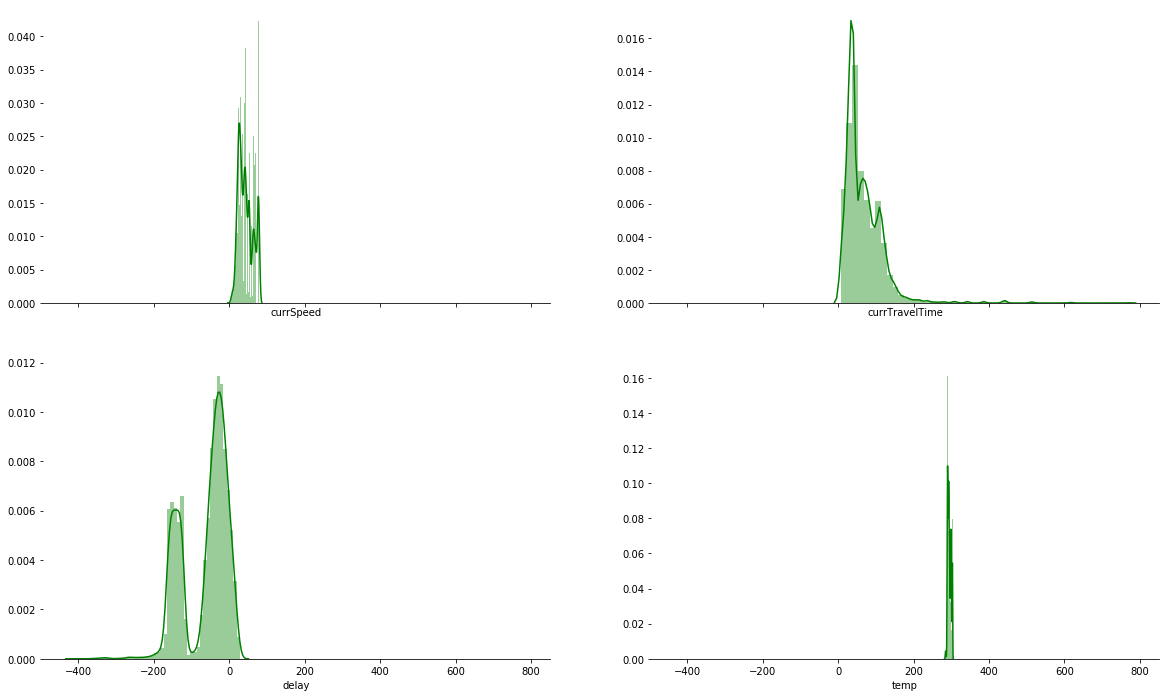

In [8]:
histograms(df, columns=['currSpeed', 'currTravelTime', 'delay', 'temp'], height=12, width=20, kde=True, color="g", multi_plot=True)

#### Histogram `delay` (przed i po czyszczeniu danych)

*  `df_without_outliners` - dane oczyszczone z wartości odstających

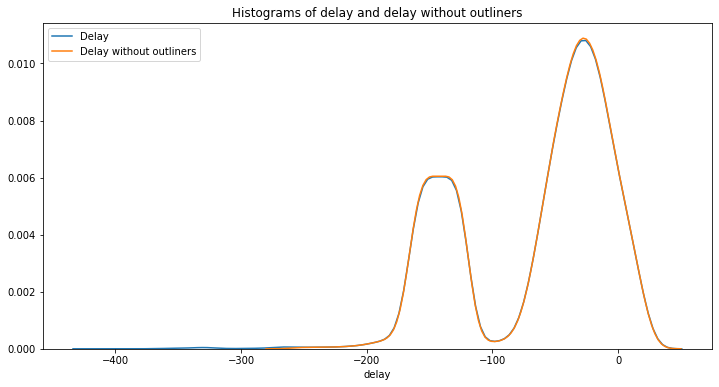

In [9]:
df_without_outliners = remove_outliers(df, columns=['delay'], error_discriminator = 1.2)

plt.figure(figsize=(12,6))
sns.distplot(a=df.delay, hist=False, label="Delay")
sns.distplot(a=df_without_outliners.delay, hist=False, label="Delay without outliners")
plt.legend()
plt.title("Histograms of delay and delay without outliners")
plt.show()

#### Spóźnienia wg przystanków

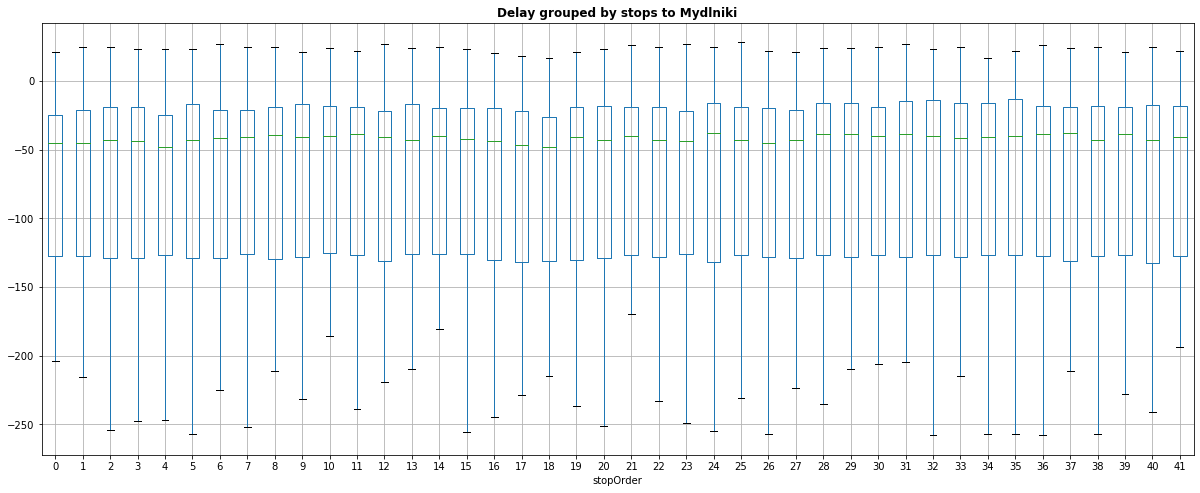

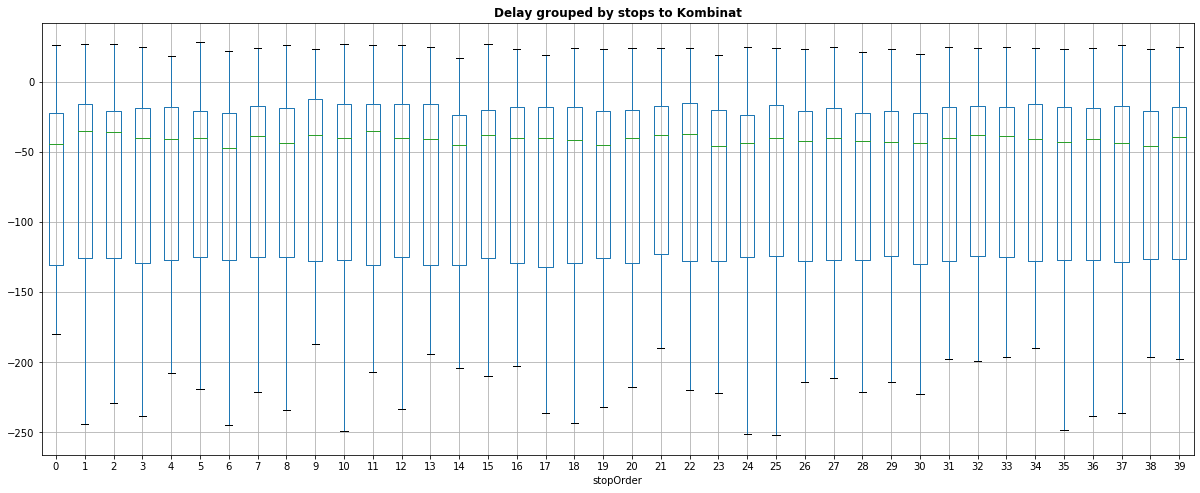

In [10]:
df_to_mydlniki = df_sort_by_stops_order[df_sort_by_stops_order.direction == "Mydlniki"]
df_to_kombinat = df_sort_by_stops_order[df_sort_by_stops_order.direction == "Kombinat"]
df_to_mydlniki = remove_outliers(df_to_mydlniki, columns = ['delay'], error_discriminator = 1.2)
df_to_kombinat = remove_outliers(df_to_kombinat, columns = ['delay'], error_discriminator = 1.2)

df_to_mydlniki.boxplot(by='stopOrder', column=['delay'], figsize=(20,8))
plt.title("Delay grouped by stops to Mydlniki", fontweight='bold')
plt.suptitle('')
df_to_kombinat.boxplot(by='stopOrder', column=['delay'], figsize=(20,8))
plt.title("Delay grouped by stops to Kombinat", fontweight='bold')
plt.suptitle('')
plt.show()

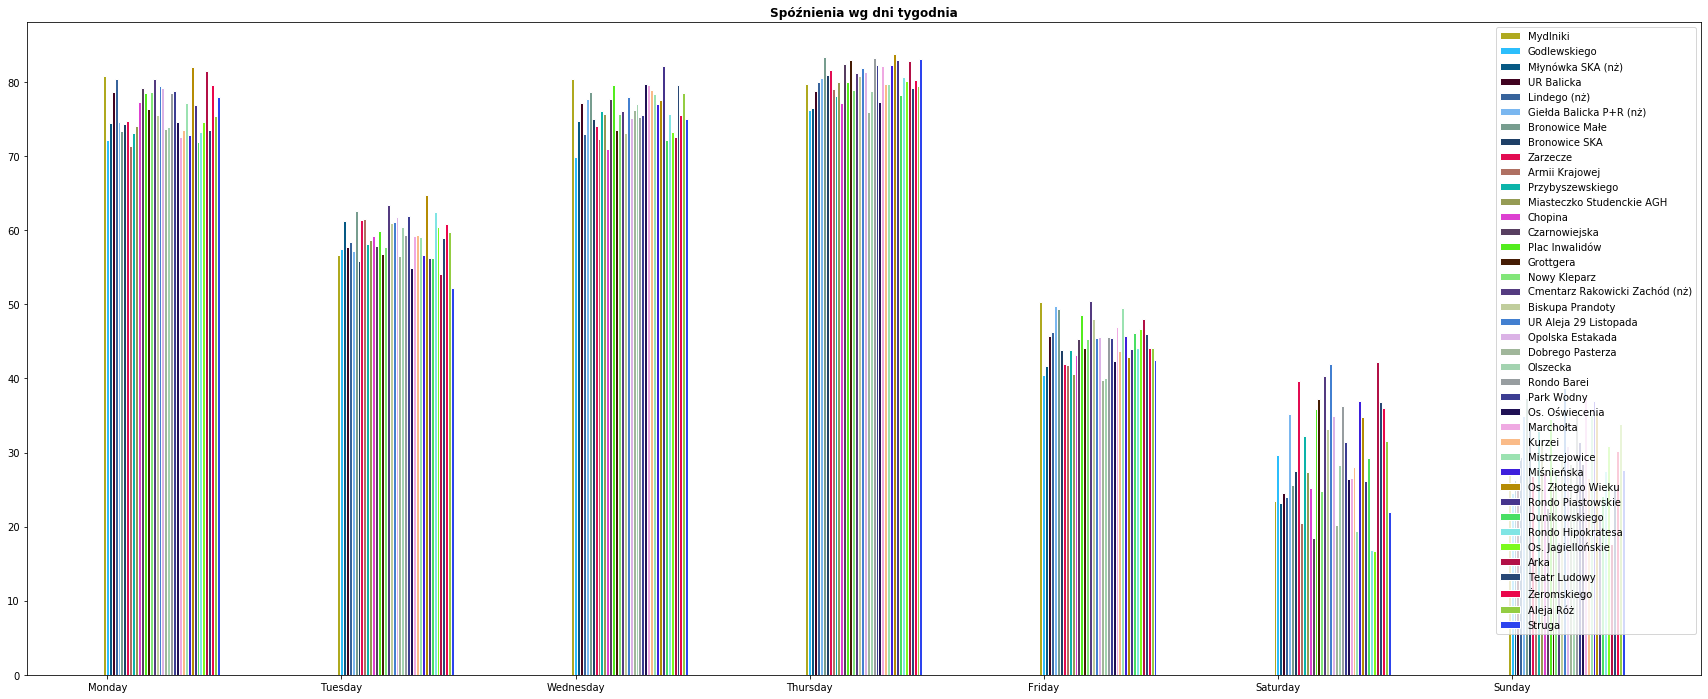

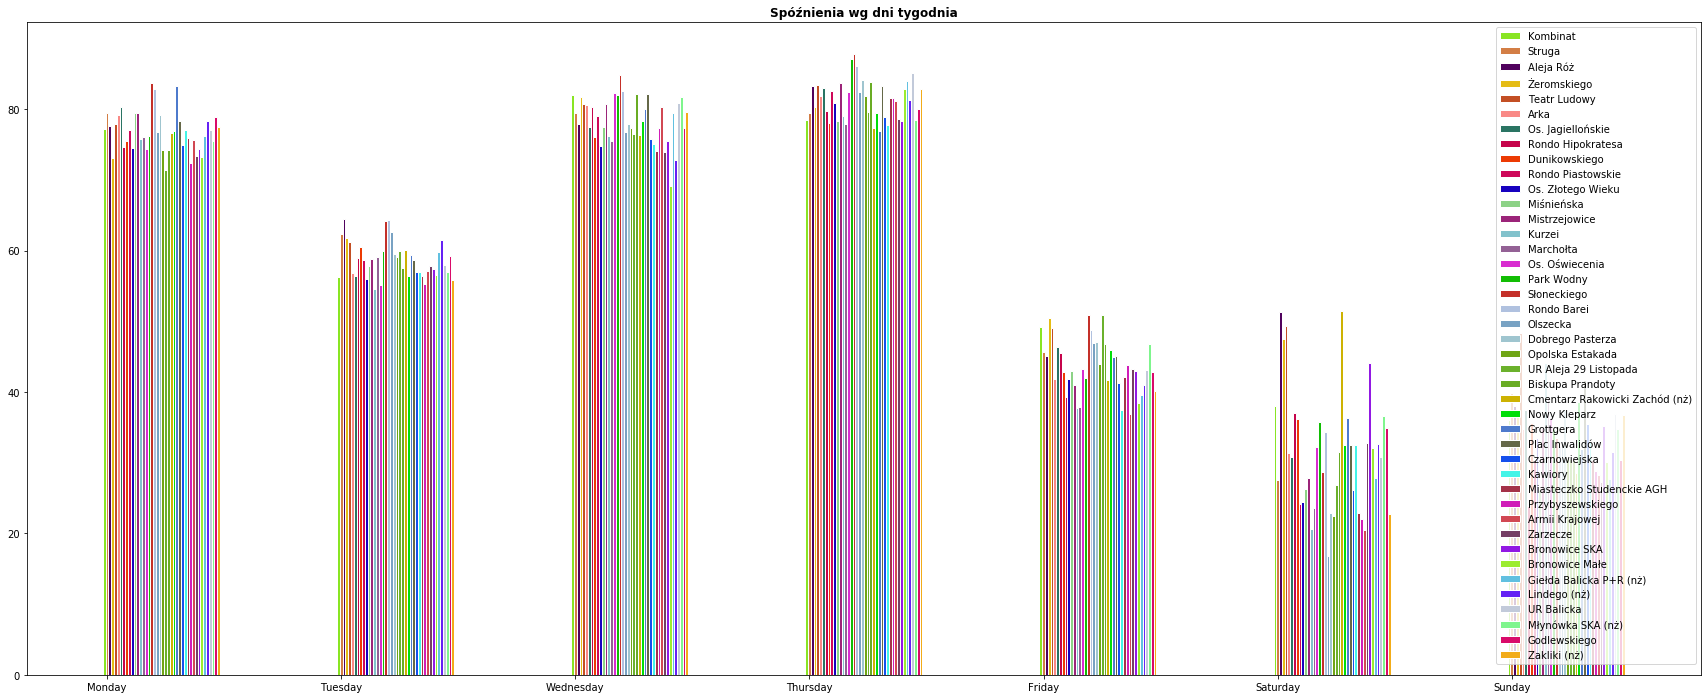

In [11]:
plot_by_days(df_to_kombinat)
plot_by_days(df_to_mydlniki)

Spóźnienia dla czterech sąsiadujących przystanków w ciągu dnia


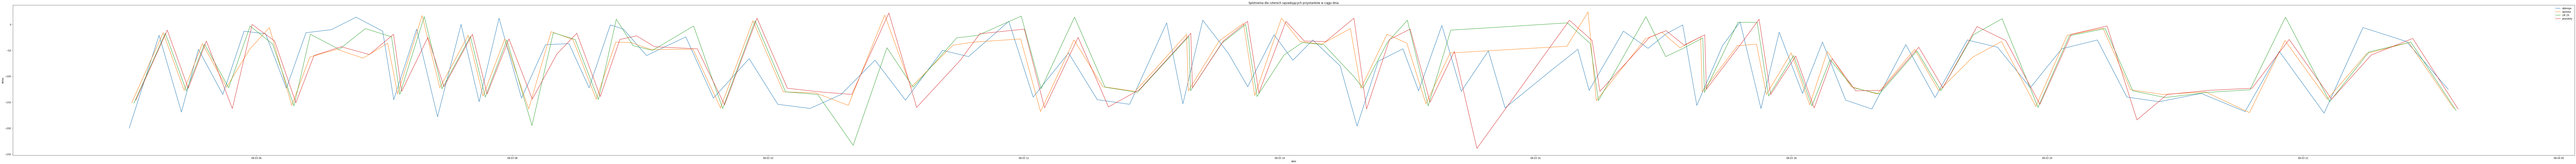

In [12]:
print('Spóźnienia dla czterech sąsiadujących przystanków w ciągu dnia')
plt.figure(figsize=(200,12))
sns.lineplot(data=df_to_mydlniki[(df_to_mydlniki.weekday == 0)&(df_to_mydlniki.stopName == 'Dobrego Pasterza')], x='date', y="delay", label="dobrego")
sns.lineplot(data=df_to_mydlniki[(df_to_mydlniki.weekday == 0)&(df_to_mydlniki.stopName == 'Opolska Estakada')], x='date', y="delay", label="opolska")
sns.lineplot(data=df_to_mydlniki[(df_to_mydlniki.weekday == 0)&(df_to_mydlniki.stopName == 'UR Aleja 29 Listopada')], x='date', y="delay", label="UR 29")
sns.lineplot(data=df_to_mydlniki[(df_to_mydlniki.weekday == 0)&(df_to_mydlniki.stopName == 'Biskupa Prandoty')], x='date', y="delay", label="prandoty")
plt.title('Spóźnienia dla czterech sąsiadujących przystanków w ciągu dnia')
plt.show()

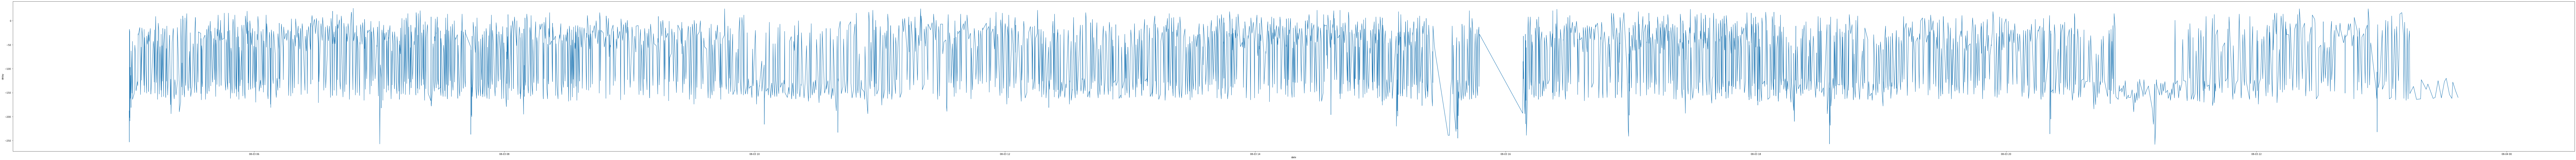

In [13]:
plt.figure(figsize=(200,12))
sns.lineplot(data=df_to_mydlniki[df_to_mydlniki.weekday == 0], x="date", y="delay")
plt.show()

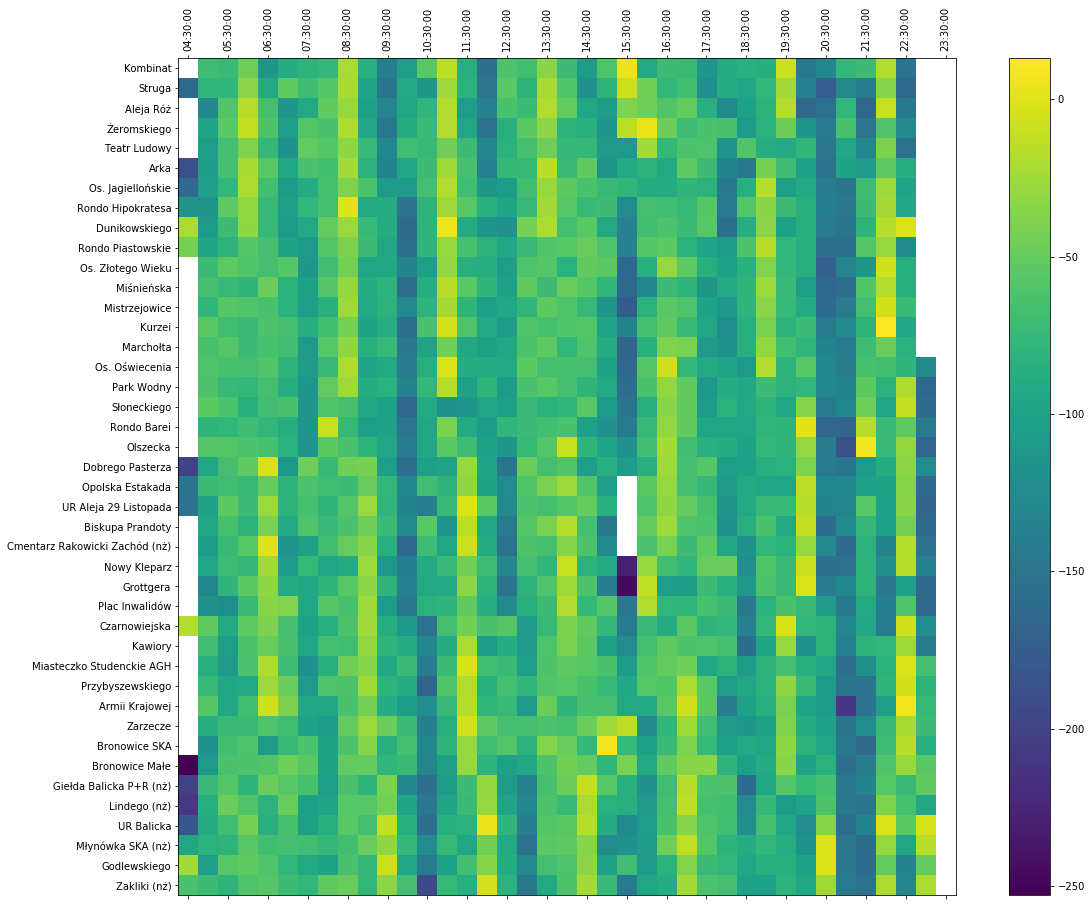

In [14]:
heatmap(df_to_mydlniki, 0)